In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# 파일 다운로드

!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2021-11-15 15:02:02--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.128, 74.125.202.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   111MB/s    in 0.6s    

2021-11-15 15:02:03 (111 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import os
import shutil

if os.path.exists('/content/cats_and_dogs_filtered/'):    # 작업 디렉토리는 cats_and_dogs_filtered
    
    shutil.rmtree('/content/cats_and_dogs_filtered/')
    print('/content/cats_and_dogs_filtered/  is removed !!!')

In [4]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile('/content/cats_and_dogs_filtered.zip', 'r') as target_file:

    target_file.extractall('/content/cats_and_dogs_filtered/') 

# ImageDataGenerator 이용하여 데이터 불러옴

In [5]:
train_data_gen = ImageDataGenerator(rescale=1./255, 
                                    rotation_range=10, width_shift_range=0.1, 
                                    height_shift_range=0.1, shear_range=0.1, 
                                    zoom_range=0.1, horizontal_flip=True,
                                    validation_split=0.2)


validation_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


test_data_gen = ImageDataGenerator(rescale=1./255)

In [6]:
train_dir = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/train'

test_dir = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

# 이미지 shape 설정

In [7]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [26]:
train_generator = train_data_gen.flow_from_directory(train_dir, batch_size=32, 
                                                color_mode='rgb', class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                subset='training')



validation_generator = validation_data_gen.flow_from_directory(train_dir, batch_size=32, 
                                                color_mode='rgb', class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                subset='validation')



test_generator = test_data_gen.flow_from_directory(test_dir, batch_size=32, 
                                              color_mode='rgb', class_mode='sparse',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [28]:
# 정답 확인

print(train_generator.class_indices.items())
print(validation_generator.class_indices.items())
print(test_generator.class_indices.items())

print(len(train_generator.classes))
print(len(validation_generator.classes))
print(len(test_generator.classes))

print(train_generator.num_classes)
print(validation_generator.num_classes)
print(validation_generator.num_classes)

print(train_generator.class_mode)
print(validation_generator.class_mode)
print(validation_generator.class_mode)

dict_items([('cats', 0), ('dogs', 1)])
dict_items([('cats', 0), ('dogs', 1)])
dict_items([('cats', 0), ('dogs', 1)])
1600
400
1000
2
2
2
sparse
sparse
sparse


# Fine Tuning 위한 pre-trained model 정의 및 모델 구축

In [29]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [30]:
model = Sequential()

model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 16)                32784     
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 20,894,298
Trainable params: 20,839,770
Non-trainable params: 54,528
_____________________________________

In [31]:
# 모델 컴파일

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['accuracy'])

In [32]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

save_file_name = './cats_and_dogs_filtered_Xception_Colab.h5'

checkpoint = ModelCheckpoint(save_file_name,       # file명을 지정
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출
                             verbose=1,            # 로그를 출력
                             save_best_only=True,  # 가장 best 값만 저장
                             mode='auto'           # auto는 알아서 best를 찾음
                            )

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=5,          # 5회 Epoch동안 개선되지 않는다면 종료
                             )


start_time = datetime.now()

hist = model.fit(train_generator, epochs=20, 
                 validation_data=validation_generator)

end_time = datetime.now()

print('elapsed time = ', end_time-start_time)

Epoch 1/20
50/50 [==============================] - 75s 1s/step - loss: 0.4834 - accuracy: 0.8388 - val_loss: 0.1502 - val_accuracy: 0.9550
Epoch 2/20
50/50 [==============================] - 69s 1s/step - loss: 0.2068 - accuracy: 0.9563 - val_loss: 0.0786 - val_accuracy: 0.9600
Epoch 3/20
50/50 [==============================] - 69s 1s/step - loss: 0.1215 - accuracy: 0.9712 - val_loss: 0.0637 - val_accuracy: 0.9700
Epoch 4/20
50/50 [==============================] - 69s 1s/step - loss: 0.0870 - accuracy: 0.9769 - val_loss: 0.0544 - val_accuracy: 0.9775
Epoch 5/20
50/50 [==============================] - 69s 1s/step - loss: 0.0669 - accuracy: 0.9831 - val_loss: 0.0555 - val_accuracy: 0.9750
Epoch 6/20
50/50 [==============================] - 69s 1s/step - loss: 0.0425 - accuracy: 0.9925 - val_loss: 0.0545 - val_accuracy: 0.9775
Epoch 7/20
50/50 [==============================] - 69s 1s/step - loss: 0.0389 - accuracy: 0.9919 - val_loss: 0.0605 - val_accuracy: 0.9750
Epoch 8/20
50/50 [==

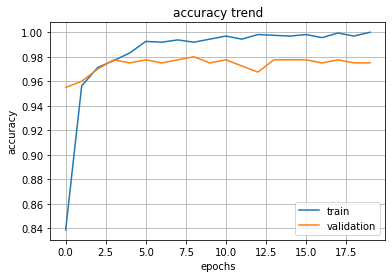

In [33]:
import matplotlib.pyplot as plt

plt.title('accuracy trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend(loc='best')
plt.show()

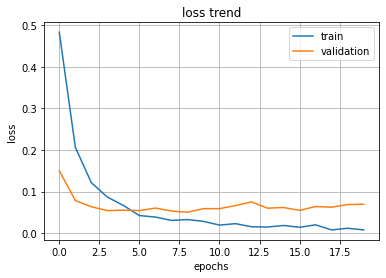

In [34]:
import matplotlib.pyplot as plt

plt.title('loss trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.show()

# test data evaluation

In [35]:
model.evaluate(test_generator)

32/32 [==============================] - 10s 299ms/step - loss: 0.0299 - accuracy: 0.9890


[0.02990957722067833, 0.9890000224113464]

# 테스트 이미지 확인

In [19]:
import zipfile

with zipfile.ZipFile('/content/test_dir.zip', 'r') as target_file:

    target_file.extractall('/content/test_dir/')

In [36]:
import cv2
import glob

test_img_list = []

test_img_name_list = glob.glob('/content/test_dir/*')

for i in range(len(test_img_name_list)):

    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))

    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    dst_img = dst_img / 255.0

    test_img_list.append(dst_img)

print(test_img_name_list)
print(len(test_img_list))

['/content/test_dir/test2.png', '/content/test_dir/test1.jpg', '/content/test_dir/test4.jpg', '/content/test_dir/test6.png', '/content/test_dir/test3.jpg', '/content/test_dir/test5.jpg']
6


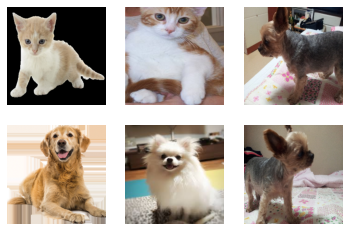

In [37]:
plt.figure(figsize=(6,4))

for i in range(len(test_img_list)):

    plt.subplot(2, 3, i+1)
    plt.axis('off')
    plt.imshow(test_img_list[i])

plt.show()

In [38]:
for i in range(len(test_img_list)):

    print(test_img_list[i].shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [39]:
# predict 수행하기 위해 batch 차원 추가
import numpy as np

print(np.array(test_img_list).shape)

(6, 224, 224, 3)


In [40]:
# predict 실행

class_name = [ 'cat', 'dog' ]  # ImageDataGenerator 에서 cat=0, dog=1

pred = model.predict(np.array(test_img_list))

print(pred.shape)
print(pred)

(6, 2)
[[9.9985969e-01 1.4024804e-04]
 [9.9951768e-01 4.8236697e-04]
 [4.8417943e-03 9.9515814e-01]
 [2.8046037e-04 9.9971956e-01]
 [4.3511081e-02 9.5648897e-01]
 [4.5746225e-03 9.9542540e-01]]


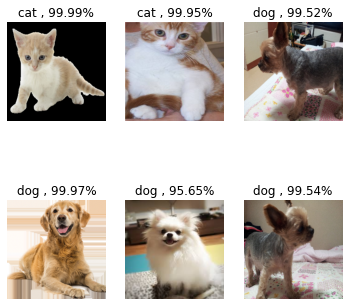

In [41]:
class_name = [ 'cat', 'dog' ]  # ImageDataGenerator 에서 cat=0, dog=1

plt.figure(figsize=(6,6))

for i in range(len(pred)):

    plt.subplot(2, 3, i+1)
    prediction = str(class_name[np.argmax(pred[i])])
    probility = '{0:0.2f}'.format(100*max(pred[i]))
    title_str = prediction + ' , ' + probility + '%'
    plt.axis('off')
    plt.title(title_str)
    plt.imshow(test_img_list[i])

plt.show()